<a href="https://colab.research.google.com/github/Cralsic123/Classifier-Based-Evaluation-of-Image-Feature-Importance/blob/main/Classifier_Based_Evaluation_of_Image_Feature_Importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [9]:
import numpy as np
import imageio
import matplotlib as plt
from scipy import ndimage
grad_cam = imageio.imread('/content/Kitten/Grad-CAM.png')  # Assuming Grad-CAM.png is the filename of your Grad-CAM image
kitten = imageio.imread('/content/Kitten/kitten.jpeg')  # Assuming Kitten.jpeg is the filename of your ground truth image

gt_height, gt_width, _ = kitten.shape
cam_height, cam_width, _ = grad_cam.shape

scale_height = gt_height / cam_height
scale_width = gt_width / cam_width

zoomed_cam = ndimage.zoom(grad_cam, (scale_height, scale_width, 1))


<ipython-input-9-d054a62e470e>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grad_cam = imageio.imread('/content/Kitten/Grad-CAM.png')  # Assuming Grad-CAM.png is the filename of your Grad-CAM image
<ipython-input-9-d054a62e470e>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kitten = imageio.imread('/content/Kitten/kitten.jpeg')  # Assuming Kitten.jpeg is the filename of your ground truth image


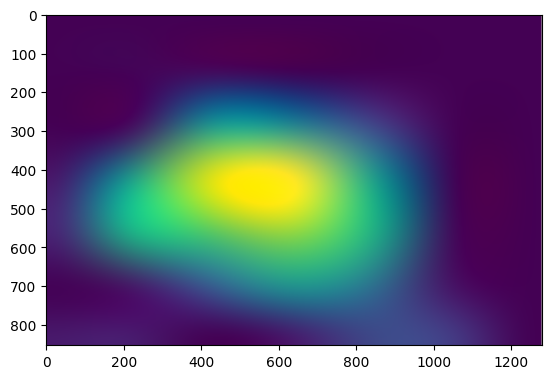

In [10]:
plt.imshow(zoomed_cam)
plt.show()

In [11]:
imageio.imsave('Zoomed_Grad_CAM.png', zoomed_cam)

In [16]:
import os
def Zoom(img_path):
  grad_cam = imageio.imread(img_path)  # Assuming Grad-CAM.png is the filename of your Grad-CAM image
  kitten = imageio.imread('/content/Kitten/kitten.jpeg')  # Assuming Kitten.jpeg is the filename of your ground truth image

  gt_height, gt_width, _ = kitten.shape
  cam_height, cam_width, _ = grad_cam.shape

  scale_height = gt_height / cam_height
  scale_width = gt_width / cam_width

  zoomed_cam = ndimage.zoom(grad_cam, (scale_height, scale_width, 1))
  name = "Zoomed_" + os.path.basename(img_path)
  imageio.imsave(name, zoomed_cam)

In [17]:
Zoom("/content/Kitten/Faster-Score-CAM.png")
Zoom("/content/Kitten/Grad-CAM++.png")
Zoom("/content/Kitten/LIME1.png")
Zoom("/content/Kitten/Score-CAM.png")
Zoom("/content/Kitten/Segmentation1.png")
Zoom("/content/Kitten/Superimposed.png")

<ipython-input-16-45e2f2ef43af>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grad_cam = imageio.imread(img_path)  # Assuming Grad-CAM.png is the filename of your Grad-CAM image
<ipython-input-16-45e2f2ef43af>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kitten = imageio.imread('/content/Kitten/kitten.jpeg')  # Assuming Kitten.jpeg is the filename of your ground truth image


In [18]:
original_image = cv2.imread('/content/Kitten/kitten.jpeg')
explanation_heatmaps = [
    cv2.imread('Zoomed_Superimposed.png'),
    cv2.imread('Zoomed_Segmentation1.png'),
    cv2.imread('Zoomed_Score-CAM.png'),
    cv2.imread('Zoomed_LIME1.png'),
    cv2.imread('Zoomed_Faster-Score-CAM.png'),
    cv2.imread('Zoomed_Grad-CAM++.png'),
    cv2.imread('Zoomed_Grad-CAM.png')
]

Trying to use thresholding to segment the ROI based on brightness

In [23]:
from google.colab.patches import cv2_imshow

copy=original_image
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
_, binary_threshold = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = max(contours, key=cv2.contourArea)

roi_mask = np.zeros_like(gray_image)
cv2.drawContours(roi_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

segmented_roi = cv2.bitwise_and(original_image, original_image, mask=roi_mask)

cv2_imshow(segmented_roi)
cv2.waitKey(0)
cv2.destroyAllWindows()



error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - cvtColor() missing required argument 'code' (pos 2)
>  - cvtColor() missing required argument 'code' (pos 2)
